In [ ]:
!pip install mlflow==2.17.1
!pip install optuna

In [1]:

from google.colab import userdata
import json

git_email = userdata.get('GIT_EMAIL')
git_name = userdata.get('GIT_NAME')
git_token = userdata.get('GIT_TOKEN')
gcs_token = userdata.get('GCS_TOKEN').replace("\\n", "\n")
kaggle_user = userdata.get('KAGGLE_USER')
kaggle_key = userdata.get('KAGGLE_KEY')

gcs_json = {
  "type": "service_account",
  "project_id": "david-ortiz-projects",
  "private_key_id": "fe5df8244177a2d0b63781c295cf09583b472f5c",
  "private_key": f"{gcs_token}",
  "client_email": "dvc-bucket@david-ortiz-projects.iam.gserviceaccount.com",
  "client_id": "108668645089724150009",
  "auth_uri": "https://accounts.google.com/o/oauth2/auth",
  "token_uri": "https://oauth2.googleapis.com/token",
  "auth_provider_x509_cert_url": "https://www.googleapis.com/oauth2/v1/certs",
  "client_x509_cert_url": "https://www.googleapis.com/robot/v1/metadata/x509/dvc-bucket%40david-ortiz-projects.iam.gserviceaccount.com",
  "universe_domain": "googleapis.com"
}

kaggle_json = {
    "username":f"{kaggle_user}",
    "key":f"{kaggle_key}"}

with open("/content/credentials.json", "w") as outfile:
    json.dump(gcs_json, outfile, indent=4)

!mkdir /root/.config/kaggle
with open("/root/.config/kaggle/kaggle.json", "w") as outfile:
    json.dump(kaggle_json, outfile, indent=4)

!chmod 600 /root/.config/kaggle/kaggle.json

!git config --global user.name "{git_name}"
!git config --global user.email "{git_email}"


!git clone https://{git_token}@github.com/DavidFOrtizG/mlds6.git

%cd /content/mlds6

!echo -e "['remote \"myremote\"']\n    credentialpath = ../../credentials.json" > /content/mlds6/.dvc/config.local

!pip install -r requirements.txt > /dev/null 2>&1
!dvc pull > /dev/null 2>&1

!mkdir /content/mlds6/data
!tar -xvf /content/mlds6/data_compressed/data_raw.tar -C /content/mlds6/data  > /dev/null 2>&1
!tar -xvf /content/mlds6/data_compressed/data_compressed.tar -C /content/mlds6/data > /dev/null 2>&1
!tar -xvf /content/mlds6/data_compressed/hdf5.tar -C /content/mlds6/data > /dev/null 2>&1



Cloning into 'mlds6'...
remote: Enumerating objects: 253, done.
remote: Counting objects: 100% (253/253), done.
remote: Compressing objects: 100% (171/171), done.
remote: Total 253 (delta 106), reused 206 (delta 59), pack-reused 0 (from 0)
Receiving objects: 100% (253/253), 4.33 MiB | 24.25 MiB/s, done.
Resolving deltas: 100% (106/106), done.
/content/mlds6


In [2]:
# To pull raw data from kaggle uncomment below and run this cell
# %cd /content/mlds6/scripts/data_acquisition
# !python data_download.py
# %cd /content/mlds6/

In [3]:
# To preprocess data uncomment below and run this cell. This will also generate the hdf5 version of the data
# %cd /content/mlds6/scripts/preprocessing
# !python preprocess.py
# %cd /content/mlds6/

In [4]:
import sys
import importlib
sys.path.append("/content/mlds6/")

from src.mlds6.preprocessing.data_generator import DataGenerator

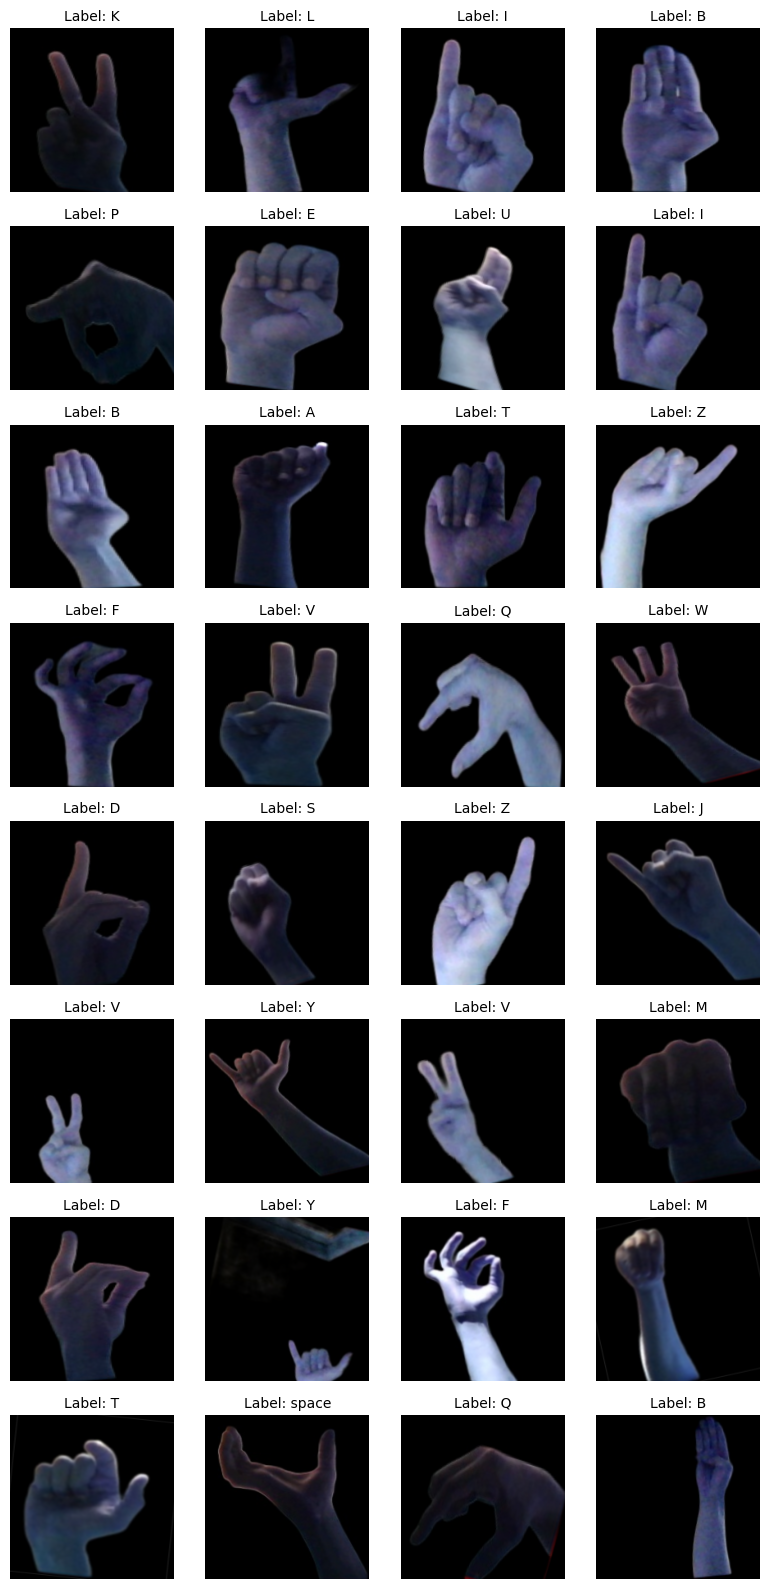

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

train_gen = DataGenerator("/content/mlds6/data/hdf5/train.hdf5", mode="train", batch_size=1024, shuffle=True)
val_gen = DataGenerator("/content/mlds6/data/hdf5/val.hdf5", batch_size=1024, shuffle=False)
test_gen = DataGenerator("/content/mlds6/data/hdf5/test.hdf5", batch_size=1024, shuffle=False)

test_batch = train_gen[0]

X_batch = test_batch[0]
y_batch_index = np.argmax(test_batch[1], axis=1)
y_batch = [train_gen.distinct_labels[i] for i in y_batch_index]

fig, axes = plt.subplots(8, 4, figsize=(8, 16))
axes = axes.flatten()

for i, ax in enumerate(axes):
    img = (X_batch[i] + 1) / 2
    label = str(y_batch[i])
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Label: {label}", fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()

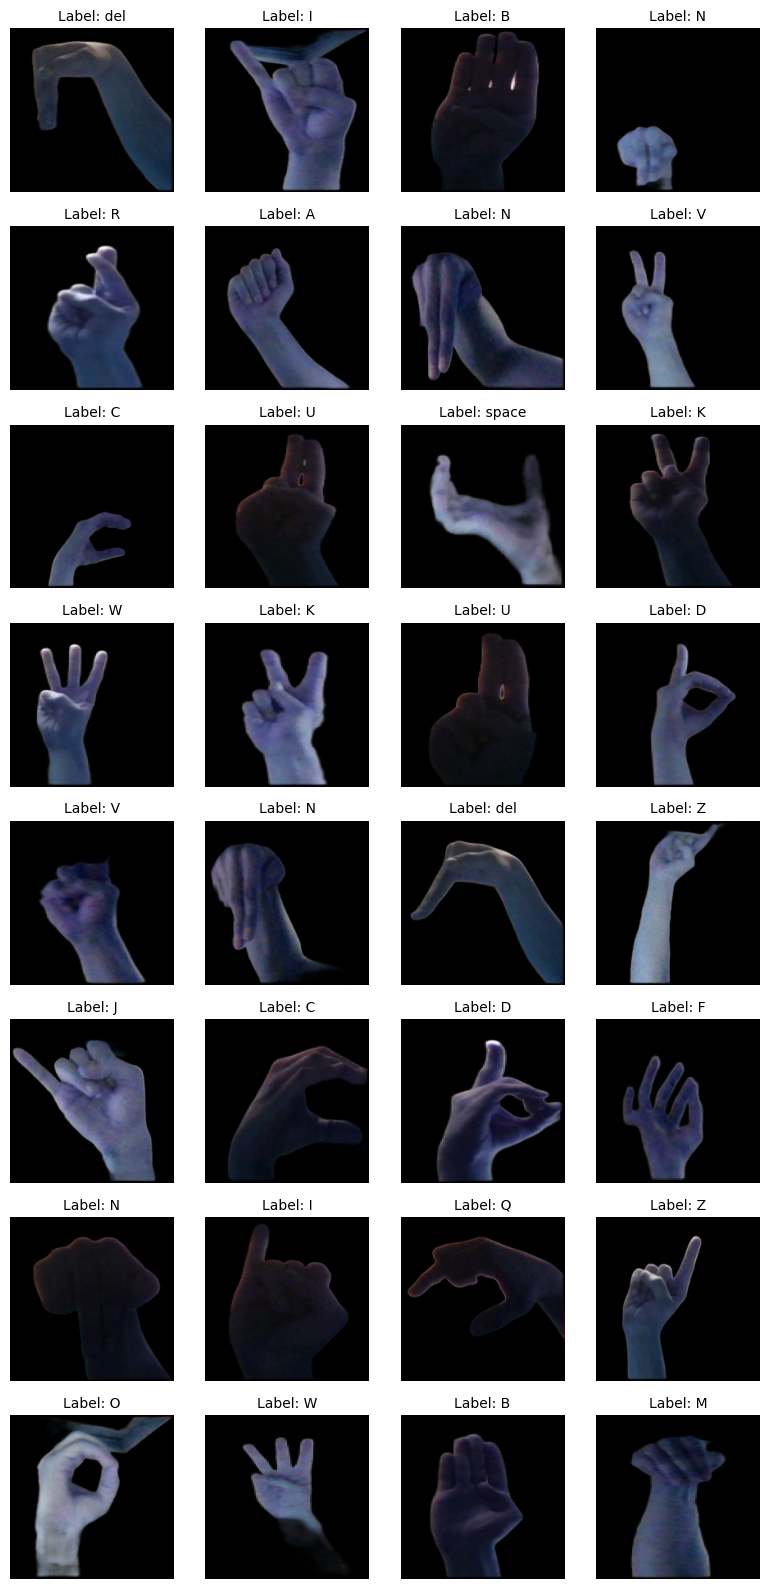

In [6]:
test_batch = val_gen[0]

X_batch = test_batch[0]
y_batch_index = np.argmax(test_batch[1], axis=1)
y_batch = [train_gen.distinct_labels[i] for i in y_batch_index]

fig, axes = plt.subplots(8, 4, figsize=(8, 16))
axes = axes.flatten()

for i, ax in enumerate(axes):
    img = (X_batch[i] + 1) / 2
    label = str(y_batch[i])
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Label: {label}", fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()

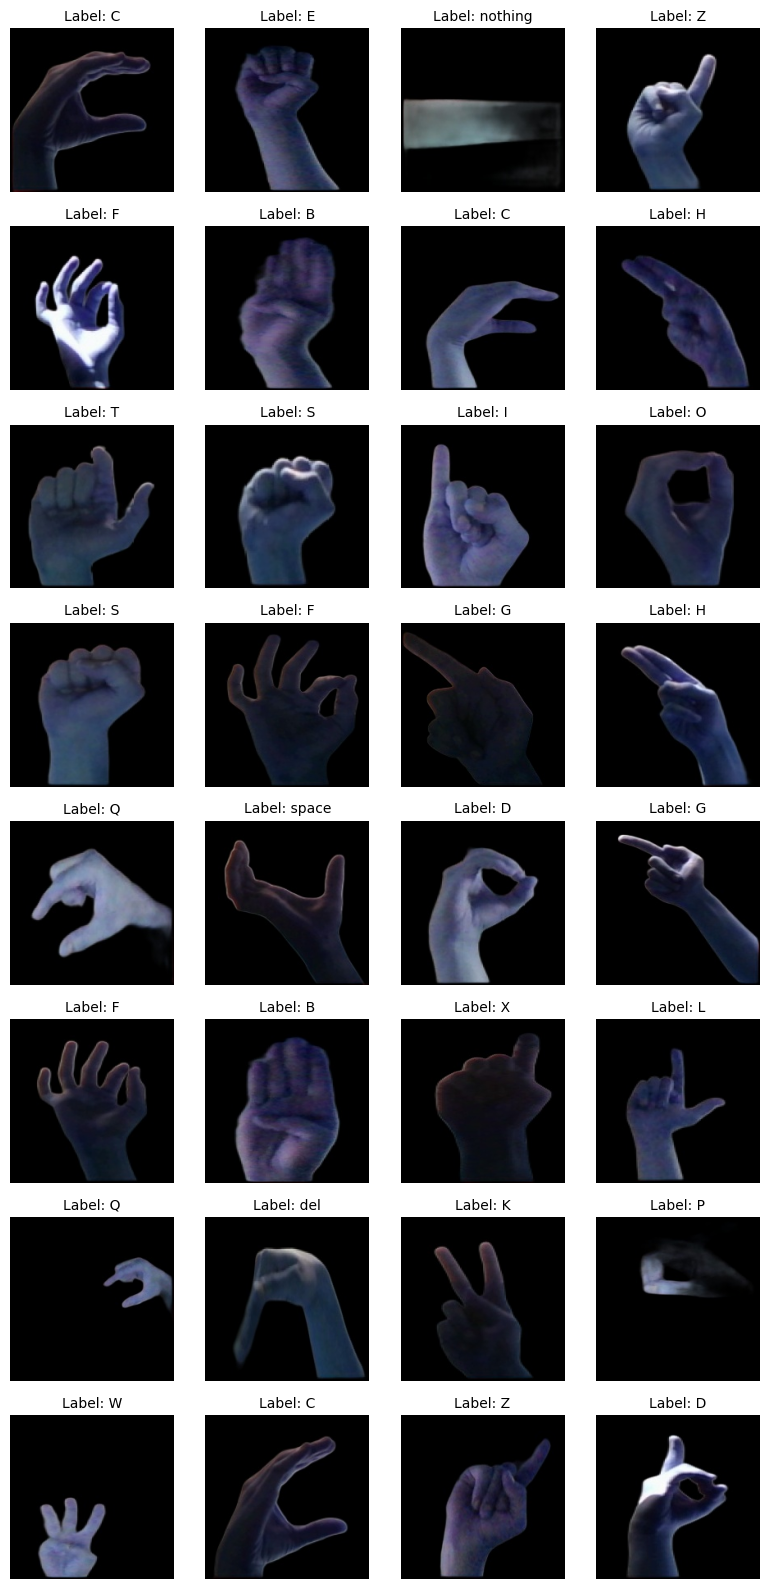

In [7]:
test_batch = test_gen[0]

X_batch = test_batch[0]
y_batch_index = np.argmax(test_batch[1], axis=1)
y_batch = [train_gen.distinct_labels[i] for i in y_batch_index]

fig, axes = plt.subplots(8, 4, figsize=(8, 16))
axes = axes.flatten()

for i, ax in enumerate(axes):
    img = (X_batch[i] + 1) / 2
    label = str(y_batch[i])
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Label: {label}", fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()

In [10]:
import os, mlflow, optuna
from sklearn.metrics import accuracy_score
from IPython import get_ipython
from IPython.display import display
#plt.style.use("ggplot")


In [11]:
command = """
mlflow server \
        --backend-store-uri sqlite:///tracking.db \
        --default-artifact-root file:mlruns \
        -p 5000 &
"""
get_ipython().system_raw(command)

In [12]:
!pip install pyngrok

In [13]:
os.environ["NGROK_TOKEN"] = userdata.get('NGROK_TOKEN')

In [14]:
!ngrok authtoken $NGROK_TOKEN

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
from pyngrok import ngrok
ngrok.connect(5000, "http", host_header="localhost")

In [18]:
mlflow.set_tracking_uri("http://localhost:5000")

In [ ]:
try:
  exp = mlflow.get_experiment_by_name("mlds6").experiment_id
except AttributeError:
  exp = mlflow.create_experiment("mlds6", artifact_location="mlruns")

## **Optimización de Hiperparametros OPTUNA**

In [ ]:
!pip install optuna-integration[tfkeras]

In [ ]:
import keras
from keras.applications import MobileNetV2
import optuna
import tensorflow as tf
from optuna.integration import TFKerasPruningCallback

def objective(trial):

    units1 = trial.suggest_int("units1", 32, 512, step=32)
    units2 = trial.suggest_int("units2", 32, 512, step=32)
    dropout = trial.suggest_float("dropout", 0.2, 0.6, step=0.1)
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)

    # Usar solo 30% del dataset para hacer más rápido el tuning
    #fraction = 0.3
    # steps_per_epoch = int(train_gen * fraction / train_gen.batch_size)
    # validation_steps = int(val_gen.n * fraction / val_gen.batch_size)

    extractor = MobileNetV2(
        weights="imagenet",
        include_top=False,
        input_shape=(200, 200, 3)
    )

    for layer in extractor.layers:
        layer.trainable = False

    x = keras.layers.GlobalAveragePooling2D()(extractor.output)
    x = keras.layers.Dropout(dropout)(x)
    x = keras.layers.Dense(units1, activation="relu")(x)
    x = keras.layers.Dense(units2, activation="relu")(x)
    outputs = keras.layers.Dense(29, activation="softmax")(x)

    tl_model = keras.Model(inputs=extractor.input, outputs=outputs)

    tl_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2),
        TFKerasPruningCallback(trial, "val_loss"),
    ]

    with mlflow.start_run(nested=True):

        mlflow.log_params(trial.params)

        #fraction = 0.2

        #step_per_epoch = max(1,
        #                     int(traing_gen.samples * fraction / train_gen.batch_size))
        #validation_steps = max(1,
        #                       int(val_gen.samples * fraction / val_gen.batch_size))


        hist_tl = tl_model.fit(
            train_gen,
            #steps_per_epoch=steps_per_epoch,
            validation_data=val_gen,
            #validation_steps=validation_steps,
            epochs=6,
            callbacks=callbacks,
            verbose=0
        )

        val_acc = max(hist_tl.history["val_accuracy"])
        mlflow.log_metric("val_accuracy", val_acc)

    return val_acc

In [ ]:
study = optuna.create_study(direction="minimize",
                            storage="sqlite:///optuna.db",
                            study_name="mlds6_optuna_tl_MobileNetV2",
                            load_if_exists=True,
                            pruner=optuna.pruners.MedianPruner(
                                n_startup_trials=5,
                                n_warmup_steps=2
                            )
)
study.optimize(objective, n_trials=10, n_jobs=1, timeout=3600)

[I 2025-12-04 03:35:57,628] Using an existing study with name 'mlds6_optuna_tl_MobileNetV2' instead of creating a new one.
/tmp/ipython-input-2008606735.py:19: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  extractor = MobileNetV2(
2025/12/04 03:42:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run glamorous-toad-642 at: http://localhost:5000/#/experiments/0/runs/40c42be5f1784255a4d211b21ca8473a.
2025/12/04 03:42:57 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/0.
[I 2025-12-04 03:42:57,652] Trial 2 finished with value: 0.925537109375 and parameters: {'units1': 384, 'units2': 480, 'dropout': 0.5, 'lr': 0.00017099222911881183}. Best is trial 2 with value: 0.925537109375.
/tmp/ipython-input-2008606735.py:19: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192

In [26]:
print("Best Hyperparameters:", study.best_params)

Best Hyperparameters: {'units1': 384, 'units2': 256, 'dropout': 0.5, 'lr': 1.1291389435746211e-04}


In [20]:
import numpy as np
import keras
from keras.applications import MobileNetV2

extractor = MobileNetV2(
    weights= "imagenet",
    include_top=False,
    input_shape=(200,200,3),
    # include_preprocessing=False
)

#congelar capas
for layer in extractor.layers:
  layer.trainable=False

pool = keras.layers.GlobalAveragePooling2D()(extractor.output)
drop1 = keras.layers.Dropout(0.5)(pool)
dense1 = keras.layers.Dense(384, activation="relu")(drop1)
dense2 = keras.layers.Dense(256, activation="relu")(dense1)
dense3 = keras.layers.Dense(29, activation="softmax")(dense2)
tl_model = keras.Model(inputs=extractor.input, outputs=dense3)

tl_model.summary()

/tmp/ipython-input-3513962666.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  extractor = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 100, 100,  │        864 │ input_layer_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 100, 100,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 100, 100,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 100, 100,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 100, 100,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 100, 100,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 100, 100,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 100, 100,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 100, 100,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 100, 100,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 100, 100,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 101, 101,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 50, 50,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 50, 50,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 50, 50,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 50, 50,    │      2,304 │ block_1_depthwis

 Total params: 2,855,901 (10.89 MB)

 Trainable params: 597,917 (2.28 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [21]:
tl_model.compile(optimizer =keras.optimizers.Adam(learning_rate=1.1291389435746211e-04),
                 loss = keras.losses.CategoricalCrossentropy(),
                 metrics = ["accuracy"])

In [22]:
callback = keras.callbacks.ModelCheckpoint(
    filepath="transfer_learning_model.weights.h5",
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

hist_tl = tl_model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen,
    callbacks=[callback],
)


Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.1286 - loss: 3.2325 - val_accuracy: 0.6501 - val_loss: 1.6475
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 59s 999ms/step - accuracy: 0.5601 - loss: 1.6644 - val_accuracy: 0.8267 - val_loss: 0.7049
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 59s 995ms/step - accuracy: 0.7307 - loss: 0.9515 - val_accuracy: 0.8740 - val_loss: 0.4995
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 59s 995ms/step - accuracy: 0.7987 - loss: 0.7132 - val_accuracy: 0.8911 - val_loss: 0.4204
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 59s 994ms/step - accuracy: 0.8205 - loss: 0.6320 - val_accuracy: 0.9038 - val_loss: 0.3720
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 59s 993ms/step - accuracy: 0.8396 - loss: 0.5659 - val_accuracy: 0.9096 - val_loss: 0.3441
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 59s 998ms/step - accuracy: 0.8516 - loss: 0.5208 - val_accuracy: 0.9164 - val_loss: 0.3116
Epoch 8/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 59s 997ms/step - accuracy: 0.8587 - loss: 0.4921 - val_accura

In [26]:
### Fine Tuning ###

for layer in tl_model.layers:
  layer.trainable = True

# Disminuimos el learning rate

tl_model.compile(optimizer= keras.optimizers.Adam(learning_rate= 0.00001),
                 loss = keras.losses.CategoricalCrossentropy(),
                 metrics = ['accuracy'])

# Cargar los pesos del calentamiento

tl_model.load_weights("transfer_learning_model.weights.h5")

callback = keras.callbacks.ModelCheckpoint(filepath="fine_tuning.weights.h5",
                                                monitor="val_loss",
                                                verbose=False,
                                                save_best_only=True,
                                                save_weights_only=True,
                                                mode="min")

# Entrenamos

hist_ft = tl_model.fit(train_gen, epochs=20, callbacks=callback, validation_data=val_gen)

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 257s 1s/step - accuracy: 0.4160 - loss: 2.2504 - val_accuracy: 0.9207 - val_loss: 0.2871
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.7168 - loss: 0.9482 - val_accuracy: 0.9216 - val_loss: 0.2852
Epoch 3/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.8100 - loss: 0.6318 - val_accuracy: 0.9215 - val_loss: 0.2838
Epoch 4/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.8574 - loss: 0.4831 - val_accuracy: 0.9218 - val_loss: 0.2819
Epoch 5/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.8803 - loss: 0.4057 - val_accuracy: 0.9229 - val_loss: 0.2750
Epoch 6/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.8986 - loss: 0.3447 - val_accuracy: 0.9259 - val_loss: 0.2660
Epoch 7/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.9111 - loss: 0.3004 - val_accuracy: 0.9265 - val_loss: 0.2616
Epoch 8/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.9227 - loss: 0.2655 - val_accuracy: 0.9294 - val_loss

In [27]:
from sklearn.metrics import classification_report, confusion_matrix

print("Predicciones..")

predictions = tl_model.predict(test_gen)
predicted_classes = np.argmax(predictions, axis=1)




Predicciones..
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 321ms/step


In [28]:
print("Extracción de clases...")

true_classes = []
for i in range(len(test_gen)):
    _, y_batch = test_gen[i]
    true_classes.extend(np.argmax(y_batch, axis=1))

true_classes = np.array(true_classes)

class_labels = list(test_gen.distinct_labels)

print("\nReporte de Clasificación:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

Extracción de clases...

Reporte de Clasificación:
              precision    recall  f1-score   support

           A       0.98      0.98      0.98       427
           B       0.99      0.97      0.98       427
           C       1.00      0.97      0.98       422
           D       1.00      0.96      0.97       427
           E       0.97      0.98      0.97       430
           F       1.00      0.97      0.99       410
           G       0.99      0.92      0.95       425
           H       0.98      0.98      0.98       423
           I       0.98      0.92      0.95       423
           J       0.98      0.96      0.97       428
           K       0.99      0.96      0.97       426
           L       0.99      0.99      0.99       428
           M       0.96      0.97      0.96       414
           N       0.98      0.96      0.97       425
           O       0.98      0.95      0.97       421
           P       0.99      0.94      0.96       425
           Q       0.95      0

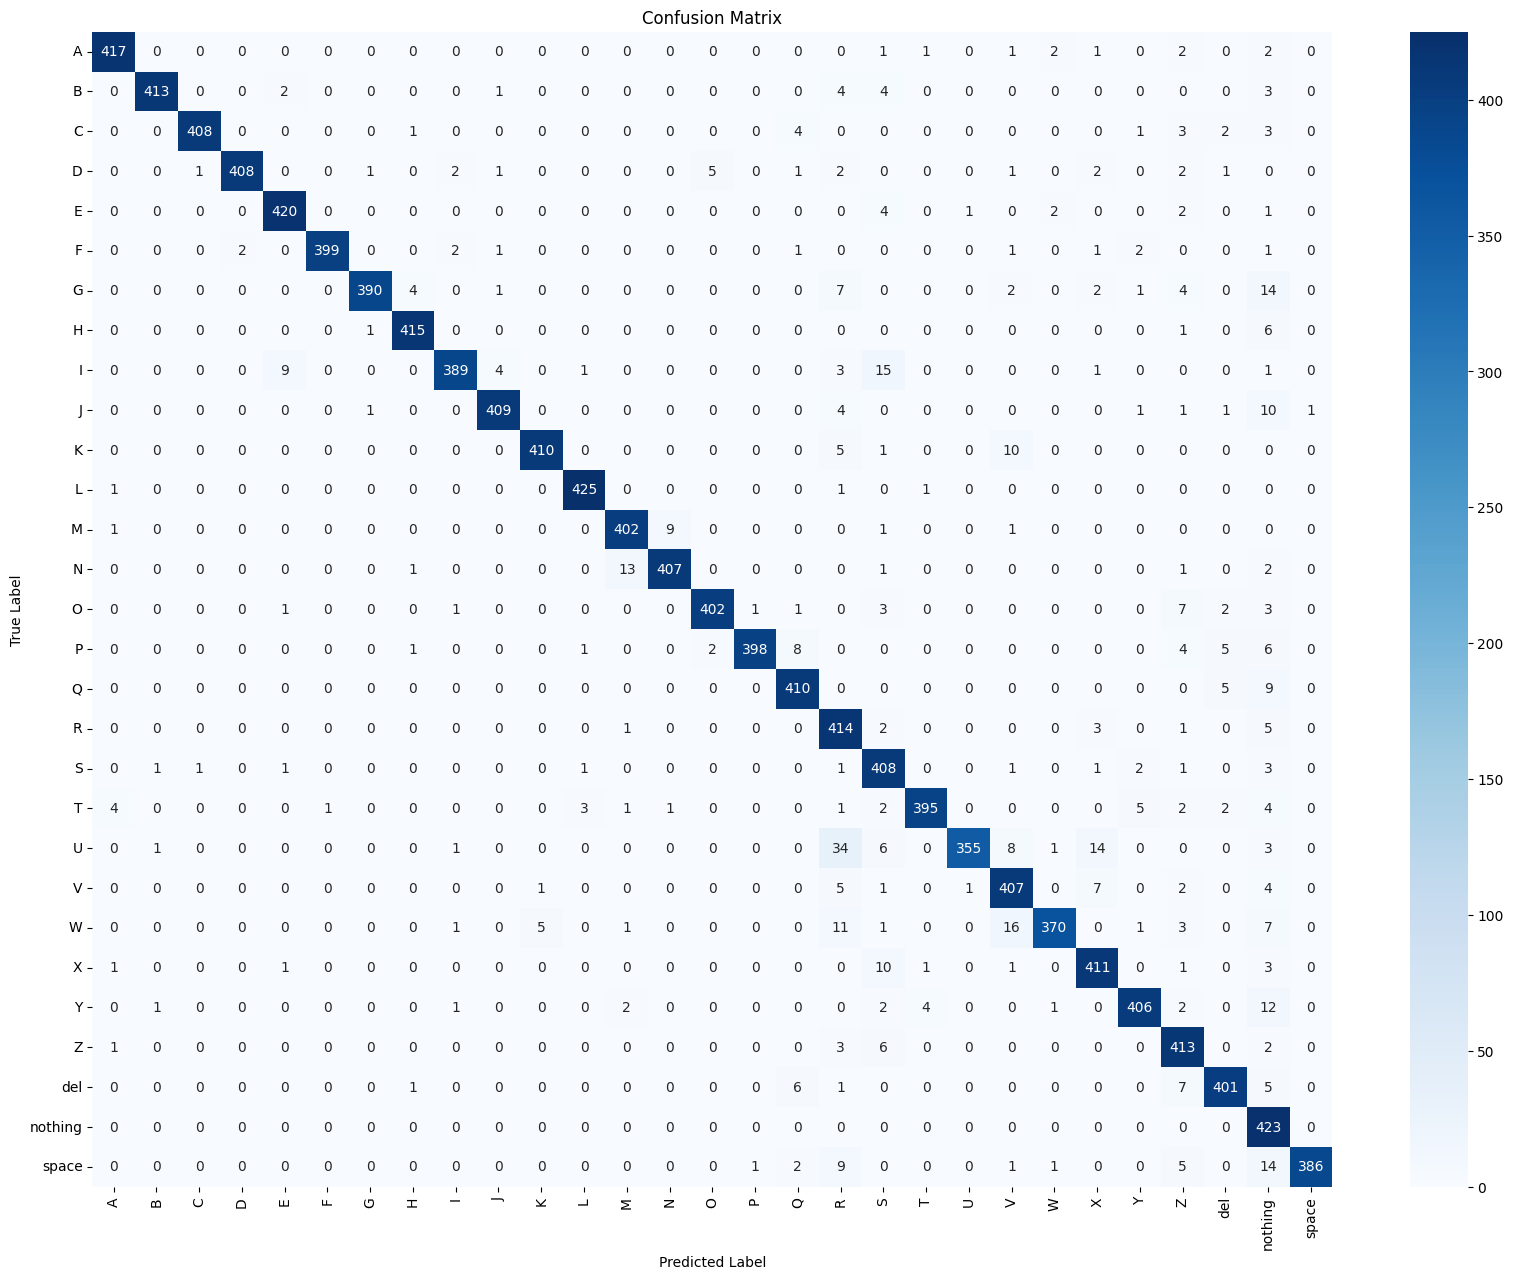

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(20, 15))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig("matrix_final.png", bbox_inches='tight')
plt.show()